# Pulse propagation in gas-filled hollow core fiber (HCF)

## Single parameter fitting

In [ ]:
import numpy as np
from scipy.special import gamma
from scipy.optimize import minimize_scalar
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from scipy.fftpack import fft, ifft, fftshift, ifftshift, fftfreq
import warnings
warnings.filterwarnings("error")

# Defining Functions for the simulation

def getPower(amplitude):
    return np.abs(amplitude) ** 2

def getGaussianWavelengthSpectrum(wavelength, wavelength0, wavelength_FWHM):
    return np.exp(-2 * np.log(2) * ((wavelength - wavelength0) / wavelength_FWHM)**2)

def getGaussianPulseTime(time, duration):
    return np.exp(-2*np.log(2)*((time)/(duration))**2)*(1+0j)

def getSpectrumFromPulse(time,pulse_amplitude):
    dt=time[1]-time[0]
    spectrum_amplitude=fftshift(fft(pulse_amplitude))*dt # Take FFT and do shift
    return spectrum_amplitude

def analyze_pulse_characteristics(x, I, rat):
    """
    Calculates the FWHM or other width-like characteristics of a pulse.
    
    Parameters:
    - x (np.array): time or frequency array
    - I (np.array): intensity array
    - rat (float): threshold ratio (e.g., 0.5 for FWHM, 0.05 for 5% bandwidth)
    - Mult (float): optional multiplier to convert units (default: 1)
    
    Prints the pulse width in appropriate units.
    """
    max_I = np.max(I)
    I_thresh = max_I * rat

    # Find indices where intensity is above the threshold
    indices = np.where(I >= I_thresh)[0]

    if indices.size == 0:
        width_x = 0
    else:
        # Guard against out-of-bounds
        if indices[0] == 0 or indices[-1] == len(x) - 1:
            print("Warning: Threshold too close to boundary. Skipping interpolation.")
            xa1 = x[indices[0]]
            xa2 = x[indices[-1]]
        else:
            # Linear interpolation around threshold crossings
            x1, x2 = x[indices[0] - 1], x[indices[0]]
            f1, f2 = I[indices[0] - 1], I[indices[0]]
            xa1 = ((I_thresh - f1) * x2 + (f2 - I_thresh) * x1) / (f2 - f1)

            x3, x4 = x[indices[-1]], x[indices[-1] + 1]
            f3, f4 = I[indices[-1]], I[indices[-1] + 1]
            xa2 = ((I_thresh - f4) * x3 + (f3 - I_thresh) * x4) / (f3 - f4)

        width_x = xa2 - xa1

    return width_x

def calculate_refractive_index(pressure_bar):
    """
    Calculate the refractive index of CO2 or He at a given 1030nm and pressure.
    
    Assumes linear pressure scaling from known value at 1 atm.
    
    Parameters:
    - pressure_bar: Pressure in bar
    
    Returns:
    - Refractive index of CO2 or He at given pressure
    """
    # Reference data: n_CO2 at 1030 nm and 1 atm (~293 K)
    n_1atm = 1.00045  # Approximate value at 1030 nm from literature: Peck and Khanna, J. Opt. Soc. Am. 56, 1059 (1966); CRC Handbook of Chemistry and Physics, 88th Ed.
    # Reference data: n_He at 1030 nm and 1 atm (~293 K)
    #n_1atm = 1.00003466  # Approximate value at 1030 nm from literature: Peck and Khanna, J. Opt. Soc. Am. 56, 1059 (1966); CRC Handbook of Chemistry and Physics, 88th Ed.
    

    atm_pressure = 1.01325  # 1 atm in bar

    delta_n = (n_1atm - 1) * (pressure_bar / atm_pressure)
    n = 1 + delta_n
    return n

def calculate_n2(pressure_bar, n2_atm):
    """
    Calculate the nonlinear refractive index n2 of CO2 or He at given pressure.

    Parameters:
    - pressure_bar: Pressure in bar
    - n2_atm: n2 of CO2 or He at 1 atm in cm^2/W

    Returns:
    - n2 in m^2/W
    """
    atm_to_bar = 1.01325
    n2_cm2_W = n2_atm * (pressure_bar / atm_to_bar)
    return n2_cm2_W * 1e-4  # convert to m^2/W

def calculate_gamma(n2_atm, pressure_bar, wavelength, core_diameter):
    """
    Calculate gamma from physical parameters and pressure-scaled n2.

    Parameters:
    - n2_atm: Nonlinear index at 1 atm (in cm^2/W)
    - pressure_bar: Gas pressure in bar
    - wavelength: Wavelength in meters
    - core_diameter: Diameter of fiber core in meters

    Returns:
    - gamma in W^-1·m^-1
    """
    n2 = calculate_n2(pressure_bar, n2_atm)
    core_radius = core_diameter / 2
    A_eff = np.pi * core_radius**2
    gamma = (2 * np.pi * n2) / (wavelength * A_eff)
    return gamma

def mittag_leffler_series(alpha, z, K=100):
    result = 0
    for k in range(K):
        result += z**k / gamma(alpha * k + 1)
    return result

def mittag_leffler_array(alpha, arg_array):
    return np.array([mittag_leffler_series(alpha, element) for element in arg_array], dtype=np.complex128)

# Defining parameters for the simulation
speedoflight_nmpfs = 300                                                         
wavelength0_nm = 1030
wavelength_FWHM_nm = 30
frequency_FWHM = wavelength_FWHM_nm * speedoflight_nmpfs / wavelength0_nm**2
duration_FWHM_fs = 0.44 /  frequency_FWHM
wavelength_frontend_nm = np.arange(730, 1331, 1)
spectrum_amplitude_frontend = getGaussianWavelengthSpectrum(wavelength_frontend_nm, wavelength0_nm, wavelength_FWHM_nm)
I_frontend = getPower(spectrum_amplitude_frontend)
speedoflight_mps = 3e8
wavelength0_m = wavelength0_nm * 1e-9
wavelength_frontend_m = wavelength_frontend_nm * 1e-9
wavelength_FWHM_m = wavelength_FWHM_nm * 1e-9
frequency0=speedoflight_mps/wavelength0_m                       
omega0=2*np.pi*frequency0                                   
core_diameter = 250e-6      
pressure = 0.5        
n2_atm = 3.0e-19 # CO2
#n2_atm = 0.35e-19 # He
true_alpha = 1.0            

# Compute parameters
refractive_index = calculate_refractive_index(pressure)
beta0 = refractive_index * (omega0 / speedoflight_mps)
#gamma_calculated = calculate_gamma(n2_atm, pressure, wavelength0_m, core_diameter)
gamma_calculated = 20

# Time, frequency and wavelength grid
N=2**10
Time_window = 50 * duration_FWHM_fs * 1e-15                                        
t = np.linspace(-Time_window/2,Time_window/2,N)                                                                                  
dt = abs(t[1] - t[0])                                   
f = fftshift(fftfreq(N,d=dt))
f_rel = f + frequency0
wavelength_rel = speedoflight_mps / f_rel
sort_idx = np.argsort(wavelength_rel)
wavelength_rel = wavelength_rel[sort_idx]

# Compute inverse Jacobian: dλ/df
inv_jacobian = (wavelength_rel**2) / (speedoflight_mps)

# Prppagation distance
z = 1

# Interpolate frontend spectrum onto simulated wavelength grid (wavelength_rel)
interp_func = interp1d(wavelength_frontend_m, I_frontend, kind='cubic', fill_value=0, bounds_error=False)
I_frontend_simgrid = interp_func(wavelength_rel)

# Normalize
I_frontend_simgrid /= np.max(I_frontend_simgrid)
#I_measured_simgrid = np.clip(I_measured_simgrid, 0, None)

initial_pulse = getGaussianPulseTime(t, duration_FWHM_fs * 1e-15)

# Reference measured spectrum (can be simulated with a known alpha)
arg_true = - gamma_calculated * beta0**(1-true_alpha) * np.exp(-1j * np.pi * true_alpha / 2) * getPower(initial_pulse) * z ** true_alpha
pulse_true = initial_pulse * mittag_leffler_array(true_alpha, arg_true)
pulse_true_fft = getSpectrumFromPulse(t,pulse_true)
spec_ref_frequency = getPower(pulse_true_fft)
spec_ref_frequency /= np.max(spec_ref_frequency)
spec_ref = spec_ref_frequency * inv_jacobian
spec_ref /= np.max(spec_ref)

# --- Loss function: spectral L2 distance ---
def spectral_loss(alpha):
    if not (0.9 < alpha < 1.0):
        return np.inf
    arg_model = - gamma_calculated * beta0**(1-alpha) * np.exp(-1j * np.pi * alpha / 2) * getPower(initial_pulse) * z ** alpha
    pulse_model = initial_pulse * mittag_leffler_array(alpha, arg_model)
    pulse_model_fft = getSpectrumFromPulse(t,pulse_model)
    spec_model_frequency = getPower(pulse_model_fft)
    spec_model_frequency /= np.max(spec_model_frequency)
    spec_model = spec_model_frequency * inv_jacobian
    spec_model /= np.max(spec_model)
    return np.sum((spec_model - spec_ref)**2)

# --- another loss function ---
def spectral_loss2(alpha):
    if not (0.9 < alpha < 1.0):
        return np.inf
    arg_model = - gamma_calculated * beta0**(1-alpha) * np.exp(-1j * np.pi * alpha / 2) * getPower(initial_pulse) * z ** alpha
    pulse_model = initial_pulse * mittag_leffler_array(alpha, arg_model)
    pulse_model_fft = getSpectrumFromPulse(t,pulse_model)
    spec_model_frequency = getPower(pulse_model_fft)
    spec_model_frequency /= np.max(spec_model_frequency)
    spec_model = spec_model_frequency * inv_jacobian
    spec_model /= np.max(spec_model)
    return np.sum((spec_model - np.mean(spec_ref))**2)

# --- Estimate alpha ---
res = minimize_scalar(spectral_loss, bounds=(0.9, 1.0), method='bounded')
fitted_alpha = res.x
print(f"Fitted alpha: {fitted_alpha}")

# Fitted spectrum with estimated alpha
arg_fit = - gamma_calculated * beta0**(1-fitted_alpha) * np.exp(-1j * np.pi * true_alpha / 2) * getPower(initial_pulse) * z ** fitted_alpha
pulse_fit = initial_pulse * mittag_leffler_array(fitted_alpha, arg_fit)
pulse_fit_fft = getSpectrumFromPulse(t, pulse_fit)
spec_fit_frequency = getPower(pulse_fit_fft)
spec_fit_frequency /= np.max(spec_fit_frequency)
spec_fit = spec_fit_frequency * inv_jacobian
spec_fit /= np.max(spec_fit)

# Frontend spectrum
spec_amplitude_frontend = getGaussianWavelengthSpectrum(wavelength_rel, wavelength0_m, wavelength_FWHM_m)
spec_frontend = getPower(spec_amplitude_frontend)

# Residual sum of squares
ss_res = spectral_loss(fitted_alpha)
# Total sum of squares
ss_tot = spectral_loss2(fitted_alpha)
# R^2 value
r_squared = 1 - (ss_res / ss_tot)
print(f"R²: {r_squared}")

# --- Plot comparison ---
plt.figure(figsize=(10,5))
plt.plot(wavelength_rel * 1e9, spec_fit, label=f"Analitical α={fitted_alpha}", linestyle='--')
plt.plot(wavelength_rel * 1e9, spec_ref, label=f"Reference α={true_alpha}")
plt.plot(wavelength_rel * 1e9, spec_frontend, label="Frontend")
plt.axis([600,2000,0,1])
plt.xlabel("Wavelength [nm]")
plt.ylabel("Normalized power spectral density [a.u.]")
plt.title(f"Spectral Matching for α Fitting, R²: {r_squared}")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Two parameter estimation with 5% bandwidth

In [ ]:
import numpy as np
from scipy.special import gamma
from scipy.optimize import minimize
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from scipy.fftpack import fft, ifft, fftshift, ifftshift, fftfreq
import warnings
warnings.filterwarnings("error")

# Defining Functions for the simulation

def getPower(amplitude):
    return np.abs(amplitude) ** 2

def getGaussianWavelengthSpectrum(wavelength, wavelength0, wavelength_FWHM):
    return np.exp(-2 * np.log(2) * ((wavelength - wavelength0) / wavelength_FWHM)**2)

def getGaussianPulseTime(time, duration):
    return np.exp(-2*np.log(2)*((time)/(duration))**2)*(1+0j)

def getSpectrumFromPulse(time,pulse_amplitude):
    dt=time[1]-time[0]
    spectrum_amplitude=fftshift(fft(pulse_amplitude))*dt # Take FFT and do shift
    return spectrum_amplitude

def analyze_pulse_characteristics(x, I, rat):
    """
    Calculates the FWHM or other width-like characteristics of a pulse.
    
    Parameters:
    - x (np.array): time or frequency array
    - I (np.array): intensity array
    - rat (float): threshold ratio (e.g., 0.5 for FWHM, 0.05 for 5% bandwidth)
    - Mult (float): optional multiplier to convert units (default: 1)
    
    Prints the pulse width in appropriate units.
    """
    max_I = np.max(I)
    I_thresh = max_I * rat

    # Find indices where intensity is above the threshold
    indices = np.where(I >= I_thresh)[0]

    if indices.size == 0:
        width_x = 0
    else:
        # Guard against out-of-bounds
        if indices[0] == 0 or indices[-1] == len(x) - 1:
            print("Warning: Threshold too close to boundary. Skipping interpolation.")
            xa1 = x[indices[0]]
            xa2 = x[indices[-1]]
        else:
            # Linear interpolation around threshold crossings
            x1, x2 = x[indices[0] - 1], x[indices[0]]
            f1, f2 = I[indices[0] - 1], I[indices[0]]
            xa1 = ((I_thresh - f1) * x2 + (f2 - I_thresh) * x1) / (f2 - f1)

            x3, x4 = x[indices[-1]], x[indices[-1] + 1]
            f3, f4 = I[indices[-1]], I[indices[-1] + 1]
            xa2 = ((I_thresh - f4) * x3 + (f3 - I_thresh) * x4) / (f3 - f4)

        width_x = xa2 - xa1

    return width_x

def calculate_refractive_index(pressure_bar):
    """
    Calculate the refractive index of CO2 or He at a given 1030nm and pressure.
    
    Assumes linear pressure scaling from known value at 1 atm.
    
    Parameters:
    - pressure_bar: Pressure in bar
    
    Returns:
    - Refractive index of CO2 or He at given pressure
    """
    # Reference data: n_CO2 at 1030 nm and 1 atm (~293 K)
    n_1atm = 1.00045  # Approximate value at 1030 nm from literature: Peck and Khanna, J. Opt. Soc. Am. 56, 1059 (1966); CRC Handbook of Chemistry and Physics, 88th Ed.
    # Reference data: n_He at 1030 nm and 1 atm (~293 K)
    #n_1atm = 1.00003466  # Approximate value at 1030 nm from literature: Peck and Khanna, J. Opt. Soc. Am. 56, 1059 (1966); CRC Handbook of Chemistry and Physics, 88th Ed.
    

    atm_pressure = 1.01325  # 1 atm in bar

    delta_n = (n_1atm - 1) * (pressure_bar / atm_pressure)
    n = 1 + delta_n
    return n

def mittag_leffler_series(alpha, z, K=100):
    result = 0
    for k in range(K):
        result += z**k / gamma(alpha * k + 1)
    return result

def mittag_leffler_array(alpha, arg_array):
    return np.array([mittag_leffler_series(alpha, element) for element in arg_array], dtype=np.complex128)

# Defining parameters for the simulation
speedoflight_nmpfs = 300                                                         
wavelength0_nm = 1030
wavelength_FWHM_nm = 30
frequency_FWHM = wavelength_FWHM_nm * speedoflight_nmpfs / wavelength0_nm**2
duration_FWHM_fs = 0.44 /  frequency_FWHM
wavelength_frontend_nm = np.arange(730, 1331, 1)
spectrum_amplitude_frontend = getGaussianWavelengthSpectrum(wavelength_frontend_nm, wavelength0_nm, wavelength_FWHM_nm)
I_frontend = getPower(spectrum_amplitude_frontend)
speedoflight_mps = 3e8
wavelength0_m = wavelength0_nm * 1e-9
wavelength_frontend_m = wavelength_frontend_nm * 1e-9
wavelength_FWHM_m = wavelength_FWHM_nm * 1e-9
frequency0=speedoflight_mps/wavelength0_m                       
omega0=2*np.pi*frequency0                                         
pressure = 0.5        
n2_atm = 3.0e-19
true_alpha = 0.95            

# Compute parameters
refractive_index = calculate_refractive_index(pressure)
beta0 = refractive_index * (omega0 / speedoflight_mps)

# Time, frequency and wavelength grid
N=2**10
Time_window = 50 * duration_FWHM_fs * 1e-15                                        
t = np.linspace(-Time_window/2,Time_window/2,N)                                                                                  
dt = abs(t[1] - t[0])                                   
f = fftshift(fftfreq(N,d=dt))
f_rel = f + frequency0
wavelength_rel = speedoflight_mps / f_rel
sort_idx = np.argsort(wavelength_rel)
wavelength_rel = wavelength_rel[sort_idx]

# Compute inverse Jacobian: dλ/df
inv_jacobian = (wavelength_rel**2) / (speedoflight_mps)

# Prppagation distance
z = 1

# Interpolate frontend spectrum onto simulated wavelength grid (wavelength_rel)
interp_func = interp1d(wavelength_frontend_m, I_frontend, kind='cubic', fill_value=0, bounds_error=False)
I_frontend_simgrid = interp_func(wavelength_rel)

# Normalize
I_frontend_simgrid /= np.max(I_frontend_simgrid)
#I_frontend_simgrid = np.clip(I_frontend_simgrid, 0, None)

initial_pulse = getGaussianPulseTime(t, duration_FWHM_fs * 1e-15)

def simulate_spectrum(alpha, gamma_value):
    arg_model = - gamma_value * beta0**(1-alpha) * np.exp(-1j * np.pi * alpha / 2) * getPower(initial_pulse) * z ** alpha
    pulse_model = initial_pulse * mittag_leffler_array(alpha, arg_model)
    pulse_model_fft = getSpectrumFromPulse(t, pulse_model)
    spec_model_freq = getPower(pulse_model_fft)
    spec_model_freq /= np.max(spec_model_freq)
    spec_model = spec_model_freq * inv_jacobian
    spec_model /= np.max(spec_model)
    return spec_model

bw_measured = 118.6 * 1e-9 # meter

def loss_bandwidth(params):
    alpha, gamma_val = params
    #if not (0.9 < alpha < 1.0) or not (1 < gamma_val < 20):
        #return np.inf
    try:
        with warnings.catch_warnings():
            warnings.simplefilter("error")  # Convert warnings to exceptions
            spec_model = simulate_spectrum(alpha, gamma_val)
            bw_sim = analyze_pulse_characteristics(wavelength_rel, spec_model, 0.05)
            if np.isnan(bw_sim) or np.isinf(bw_sim):
                return np.inf
            return (bw_sim - bw_measured) ** 2
    except (FloatingPointError, RuntimeWarning, ValueError) as e:
        return np.inf

initial_guess = [0.95, 6] # alpha and gamma respectively
bounds = [(0.90, 1.0), (1, 20)] # alpha and gamma respectively

result = minimize(loss_bandwidth, initial_guess, bounds=bounds, method='Powell')

if result.success:
    alpha_est, gamma_est = result.x
    spec_model = simulate_spectrum(alpha_est, gamma_est)
    bw_sim = analyze_pulse_characteristics(wavelength_rel, spec_model, 0.05)
    loss = (bw_sim - bw_measured) ** 2
    print(f"✅ Optimization succeeded")
    print(f"Estimated alpha: {alpha_est}")
    print(f"Estimated gamma: {gamma_est}")
    print(f"Loss Bandwidth: {loss}")
else:
    print("❌ Optimization failed:", result.message)

🎯 Why Use a Loss Landscape?

| Benefit                                | What It Tells You                                                                         |
| -------------------------------------- | ----------------------------------------------------------------------------------------- |
| 🔍 **Global minimum location**         | Where the best-fit parameters lie                                                         |
| 📉 **Sensitivity**                     | Which parameters affect the loss more — steep vs. flat regions                            |
| 🧠 **Parameter coupling / degeneracy** | Whether two parameters can compensate for each other (e.g., α↑, γ↓ still gives same loss) |
| 🛠️ **Optimizer diagnostics**          | Whether your optimizer might get stuck in local minima or flat regions                    |
| 💡 **Confidence regions**              | Regions where the loss is low → potentially acceptable solutions                          |


🧠 How to Interpret a Loss Landscape

| Shape or Feature            | Meaning                                                                                 |
| --------------------------- | --------------------------------------------------------------------------------------- |
| 🎯 **Sharp global minimum** | Well-constrained parameters, optimization is easier                                     |
| ⛰️ **Multiple minima**      | Optimization might get stuck — choose a global method like `differential_evolution`     |
| 🏔️ **Valley-shaped**       | One parameter tightly constrained, one loosely (you may have a degenerate solution set) |
| 🪨 **Flat regions**         | Poor parameter identifiability — small changes don't affect the loss                    |
| 🧩 **Ridges or couplings**  | One parameter compensates for another — they're entangled (e.g., α vs. γ)               |


## Manual and computer-aided fitting with spectrum

In [ ]:
import numpy as np
from scipy.special import gamma
from scipy.optimize import minimize
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import matplotlib
matplotlib.use('TkAgg')
from matplotlib.widgets import Slider
from matplotlib.widgets import Button
from scipy.fftpack import fft, ifft, fftshift, ifftshift, fftfreq
import warnings
warnings.filterwarnings("error")

# Defining Functions for the simulation

def getPower(amplitude):
    return np.abs(amplitude) ** 2

def getGaussianWavelengthSpectrum(wavelength, wavelength0, wavelength_FWHM):
    return np.exp(-2 * np.log(2) * ((wavelength - wavelength0) / wavelength_FWHM)**2)

def getGaussianPulseTime(amplitude, time, duration):
    return amplitude * np.exp(-2*np.log(2)*((time)/(duration))**2)*(1+0j)

def getSpectrumFromPulse(time,pulse_amplitude):
    dt=time[1]-time[0]
    spectrum_amplitude=fftshift(fft(pulse_amplitude))*dt # Take FFT and do shift
    return spectrum_amplitude

def calculate_refractive_index(pressure_bar):
    """
    Calculate the refractive index of CO2 or He at a given 1030nm and pressure.
    
    Assumes linear pressure scaling from known value at 1 atm.
    
    Parameters:
    - pressure_bar: Pressure in bar
    
    Returns:
    - Refractive index of CO2 or He at given pressure
    """
    # Reference data: n_CO2 at 1030 nm and 1 atm (~293 K)
    #n_1atm = 1.00045  # Approximate value at 1030 nm from literature: Peck and Khanna, J. Opt. Soc. Am. 56, 1059 (1966); CRC Handbook of Chemistry and Physics, 88th Ed.
    # Reference data: n_He at 1030 nm and 1 atm (~293 K)
    n_1atm = 1.00003466  # Approximate value at 1030 nm from literature: Peck and Khanna, J. Opt. Soc. Am. 56, 1059 (1966); CRC Handbook of Chemistry and Physics, 88th Ed.
    

    atm_pressure = 1.01325  # 1 atm in bar

    delta_n = (n_1atm - 1) * (pressure_bar / atm_pressure)
    n = 1 + delta_n
    return n

def calculate_n2(pressure_bar, n2_atm):
    """
    Calculate the nonlinear refractive index n2 of CO2 or He at given pressure.

    Parameters:
    - pressure_bar: Pressure in bar
    - n2_atm: n2 of CO2 or He at 1 atm in cm^2/W

    Returns:
    - n2 in m^2/W
    """
    atm_to_bar = 1.01325
    n2_cm2_W = n2_atm * (pressure_bar / atm_to_bar)
    return n2_cm2_W * 1e-4  # convert to m^2/W

def calculate_gamma(n2_atm, pressure_bar, wavelength, core_diameter):
    """
    Calculate gamma from physical parameters and pressure-scaled n2.

    Parameters:
    - n2_atm: Nonlinear index at 1 atm (in cm^2/W)
    - pressure_bar: Gas pressure in bar
    - wavelength: Wavelength in meters
    - core_diameter: Diameter of fiber core in meters

    Returns:
    - gamma in W^-1·m^-1
    """
    n2 = calculate_n2(pressure_bar, n2_atm)
    core_radius = core_diameter / 2
    A_eff = np.pi * core_radius**2
    gamma = (2 * np.pi * n2) / (wavelength * A_eff)
    return gamma

def mittag_leffler_series(alpha, z, K=150):
    result = 0
    for k in range(K):
        result += z**k / gamma(alpha * k + 1)
    return result

def mittag_leffler_array(alpha, arg_array):
    return np.array([mittag_leffler_series(alpha, element) for element in arg_array], dtype=np.complex128)

# Defining parameters for the simulation
speedoflight_nmpfs = 300                                                         
wavelength0_nm = 1030
wavelength_FWHM_nm = 5
frequency_FWHM = wavelength_FWHM_nm * speedoflight_nmpfs / wavelength0_nm**2
duration_FWHM_fs = 0.44 /  frequency_FWHM
duration_FWHM = duration_FWHM_fs * 1e-15
wavelength_frontend_nm = np.arange(730, 1331, 1)
spectrum_amplitude_frontend = getGaussianWavelengthSpectrum(wavelength_frontend_nm, wavelength0_nm, wavelength_FWHM_nm)
I_frontend = getPower(spectrum_amplitude_frontend)
speedoflight_mps = 3e8
wavelength0_m = wavelength0_nm * 1e-9
wavelength_frontend_m = wavelength_frontend_nm * 1e-9
wavelength_FWHM_m = wavelength_FWHM_nm * 1e-9
frequency0=speedoflight_mps/wavelength0_m                       
omega0=2*np.pi*frequency0                                        
core_diameter = 250e-6      
pressure = 1        
n2_atm = 3.0e-19 # CO2
#n2_atm = 0.35e-19 # He    

repetition_frequency = 50                                     # Pulse repetition frequency [Hz] 
average_power = 0.0177                                        # Pulse average power [W]
pulse_energy = average_power/repetition_frequency             # Pulse energy [J]
peak_power = pulse_energy/duration_FWHM                       # Pulse peak power [W]
amplitude=np.sqrt(peak_power)                                 # Electrical field strength amplitude in units of sqrt(W)

# Compute parameters
refractive_index = calculate_refractive_index(pressure)
beta0 = refractive_index * (omega0 / speedoflight_mps)
gamma_calculated = calculate_gamma(n2_atm, pressure, wavelength0_m, core_diameter)

# Time, frequency and wavelength grid
N=2**10
Time_window = 50 * duration_FWHM_fs * 1e-15                                        
t = np.linspace(-Time_window/2,Time_window/2,N)                                                                                  
dt = abs(t[1] - t[0])                                   
f = fftshift(fftfreq(N,d=dt))
f_rel = f + frequency0
wavelength_rel = speedoflight_mps / f_rel
sort_idx = np.argsort(wavelength_rel)
wavelength_rel = wavelength_rel[sort_idx]

# Compute inverse Jacobian: dλ/df
inv_jacobian = (wavelength_rel**2) / (speedoflight_mps)

# Propagation distance
z = 1

# Interpolate frontend spectrum onto simulated wavelength grid (wavelength_rel)
interp_func = interp1d(wavelength_frontend_m, I_frontend, kind='cubic', fill_value=0, bounds_error=False)
I_frontend_simgrid = interp_func(wavelength_rel)

# Normalize
I_frontend_simgrid /= np.max(I_frontend_simgrid)
#I_frontend_simgrid = np.clip(I_frontend_simgrid, 0, None)

# Load the CSV file, skip the header row
data = np.loadtxt("Spectrums/Meas_175.csv", delimiter=";", skiprows=1)
# Split into separate arrays
wavelength_spec_ref_nm = data[:, 0]
wavelength_spec_ref_m = wavelength_spec_ref_nm * 1e-9
I_spec_ref = data[:, 2]

# Interpolate measured spectrum onto simulated wavelength grid (wavelength_rel)
interp_func = interp1d(wavelength_spec_ref_m, I_spec_ref, kind='cubic', fill_value=0, bounds_error=False)
I_spec_ref_simgrid = interp_func(wavelength_rel)

# Normalize
I_spec_ref_simgrid /= np.max(I_spec_ref_simgrid)

"""
# --- Plot comparison ---
plt.figure(figsize=(10,5))
plt.plot(wavelength_rel * 1e9, I_spec_ref_simgrid, label=f"Reference")
plt.plot(wavelength_rel * 1e9, I_frontend_simgrid, label="Frontend")
plt.axis([800,1200,0,1])
plt.xlabel("Wavelength [nm]")
plt.ylabel("Normalized power spectral density [a.u.]")
plt.title(f"Spectrums")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
"""

"""
def simulate_spectrum_2parameter(gamma_value, FWHM):
    initial_pulse = getGaussianPulseTime(amplitude, t, FWHM)
    alpha = 1
    arg_model = - gamma_value * beta0**(1-alpha) * np.exp(-1j * np.pi * alpha / 2) * getPower(initial_pulse) * z ** alpha
    pulse_model = initial_pulse * mittag_leffler_array(alpha, arg_model)
    pulse_model_fft = getSpectrumFromPulse(t, pulse_model)
    spec_model_freq = getPower(pulse_model_fft)
    spec_model_freq /= np.max(spec_model_freq)
    spec_model = spec_model_freq * inv_jacobian
    spec_model /= np.max(spec_model)
    return spec_model

def spectral_loss_2parameter(params):
    log_gamma, log_fwhm = params
    gamma_val = 10 ** log_gamma
    FWHM = 10 ** log_fwhm
    #gamma_val, FWHM = params
    #if not (duration_FWHM < FWHM < 100 * duration_FWHM) or not (gamma_calculated < gamma_val < 1):
        #print(params)
        #return np.inf
    try:
        with warnings.catch_warnings():
            warnings.simplefilter("error")
            spec_model = simulate_spectrum_2parameter(gamma_val, FWHM)
            spec_ref = I_spec_ref_simgrid
            return np.sum((spec_model - spec_ref)**2)
    except (FloatingPointError, RuntimeWarning, ValueError) as e:
        #print(params)
        return np.inf

def spectral_loss2_2parameter(params):
    log_gamma, log_fwhm = params
    gamma_val = 10 ** log_gamma
    FWHM = 10 ** log_fwhm
    #gamma_val, FWHM = params
    #if not (duration_FWHM < FWHM < 100 * duration_FWHM) or not (gamma_calculated < gamma_val < 1):
        #print(params)
        #return np.inf
    try:
        with warnings.catch_warnings():
            warnings.simplefilter("error")
            spec_model = simulate_spectrum_2parameter(gamma_val, FWHM)
            spec_ref = I_spec_ref_simgrid
            return np.sum((spec_model - np.mean(spec_ref))**2)
    except (FloatingPointError, RuntimeWarning, ValueError) as e:
        #print(params)
        return np.inf

initial_guess = [np.log10(2 * gamma_calculated), np.log10(2 * duration_FWHM)] # gamma and FWHM respectively
bounds = [(np.log10(gamma_calculated), np.log10(10000 * gamma_calculated)), (np.log10(duration_FWHM), np.log10(100 * duration_FWHM))] # gamma and FWHM respectively

result = minimize(spectral_loss_2parameter, x0=initial_guess, bounds=bounds, method='L-BFGS-B')

gamma_fit, FWHM_fit = result.x
# Residual sum of squares
ss_res_2parameter = spectral_loss_2parameter(result.x)
# Total sum of squares
ss_tot_2parameter = spectral_loss2_2parameter(result.x)
# R² value
r_squared_2parameter = 1 - (ss_res_2parameter / ss_tot_2parameter)
print(f"Results with 2 parameter fitting:")
print(f"Fitted gamma: {10**gamma_fit}")
print(f"Pulse amplitude: {amplitude}")
print(f"Fitted FWHM: {10**FWHM_fit}")
print(f"R²: {r_squared_2parameter}")
"""

# --- Global state to keep buttons alive ---
buttons = []

# Create figure and axes
fig, ax = plt.subplots()
plt.subplots_adjust(left=0.25, bottom=0.55)  # Extra space for sliders

# Initial parameter values
alpha_init = 1
gamma_init = gamma_calculated
z_init = z                       
amp_init = 1                          
fwhm_init = duration_FWHM_fs        

# --- Simulation Function ---
def run_sim(alpha, gamma, z, amp_scale, fwhm_fs):
    try:
        pulse = getGaussianPulseTime(amplitude, t, fwhm_fs * 1e-15) * amp_scale
        power = getPower(pulse)
        arg_model = - gamma * beta0**(1 - alpha) * np.exp(-1j * np.pi * alpha / 2) * power * z ** alpha
        pulse_model = pulse * mittag_leffler_array(alpha, arg_model)
        spectrum = getSpectrumFromPulse(t, pulse_model)
        I_sim = getPower(spectrum)
        if np.max(I_sim) == 0 or np.isnan(np.max(I_sim)):
            return np.zeros_like(I_sim)
        I_sim /= np.max(I_sim)
        I_sim *= inv_jacobian
        I_sim /= np.max(I_sim)
        print(f"α = {alpha:.5f}, γ = {gamma:.5e}, Amplitude = {amp_scale*amplitude:.0f}, FWHM = {fwhm_fs:.0f}")
        return I_sim
    except Exception as e:
        print(f"Simulation error: {e}")
        return np.zeros_like(inv_jacobian)

# --- Initial plot ---
spectrum = run_sim(alpha_init, gamma_init, z_init, amp_init, fwhm_init)
l, = ax.plot(wavelength_rel * 1e9, spectrum, label='Simulated')
l2, = ax.plot(wavelength_rel * 1e9, I_spec_ref_simgrid, '--', label='Measured')

# R² text placeholder
r2_text = ax.text(0.02, 0.95, '', transform=ax.transAxes, fontsize=10, verticalalignment='top')

ax.set_xlabel("Wavelength [nm]")
ax.set_ylabel("Normalized Intensity")
ax.set_title("Fractional Propagation Simulation")
ax.grid(True)
ax.set_ylim(0, 1)
ax.set_xlim(900, 1200)
ax.legend()

# --- Slider axes ---
ax_alpha = plt.axes([0.25, 0.42, 0.65, 0.03])
ax_log_gamma = plt.axes([0.25, 0.35, 0.65, 0.03])
ax_log_amp = plt.axes([0.25, 0.21, 0.65, 0.03])
ax_fwhm = plt.axes([0.25, 0.14, 0.65, 0.03])

# --- Sliders ---
slider_alpha = Slider(ax_alpha, 'Alpha (α)', 0.99, 1.0, valinit=alpha_init, valstep=0.0001)
slider_log_gamma = Slider(ax_log_gamma, 'log₁₀(γ)', np.log10(gamma_init), np.log10(1e-1), valinit=np.log10(gamma_init), valstep=0.01)
slider_log_amp = Slider(ax_log_amp, 'log₁₀(Amp_scale)', np.log10(1e-2), np.log10(1e2), valinit=np.log10(amp_init), valstep=0.01)
slider_fwhm = Slider(ax_fwhm, 'Input_FWHM', 0.1*fwhm_init, 10*fwhm_init, valinit=fwhm_init, valstep=1.0)

def add_arrow_buttons(y_pos, slider, step=None):
    if step is None:
        step = slider.valstep or 0.01

    ax_left = plt.axes([0.05, y_pos, 0.04, 0.03])
    ax_right = plt.axes([0.10, y_pos, 0.04, 0.03])
    btn_left = Button(ax_left, '←')
    btn_right = Button(ax_right, '→')

    def left(event):
        val = slider.val - step
        val = max(val, slider.valmin)
        slider.set_val(val)

    def right(event):
        val = slider.val + step
        val = min(val, slider.valmax)
        slider.set_val(val)

    btn_left.on_clicked(left)
    btn_right.on_clicked(right)

    # Optional: label text for context (e.g., 'α')
    ax_label = plt.axes([0.15, y_pos, 0.05, 0.03])
    ax_label.axis("off")

# --- Update function ---
def update(val):
    alpha = slider_alpha.val
    gamma = 10 ** slider_log_gamma.val
    amp = 10 ** slider_log_amp.val
    fwhm_fs = slider_fwhm.val

    # Run simulation
    new_spec = run_sim(alpha, gamma, z, amp, fwhm_fs)
    l.set_ydata(new_spec)

    # Compute R²
    y_true = I_spec_ref_simgrid
    y_pred = new_spec
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    r_squared = 1 - (ss_res / ss_tot)

    # Update title and R² text
    ax.set_title(f"α = {alpha:.4f}, γ = {gamma:.2e}, Amp_scale = {amp:.2f}, FWHM = {fwhm_fs:.1f} fs")
    r2_text.set_text(f"R² = {r_squared:.5f}")
    fig.canvas.draw_idle()

# --- Add arrow buttons to left side ---
def add_arrow_buttons(y_pos, slider, step=None):
    if step is None:
        step = slider.valstep or 0.01

    # Create left arrow button
    ax_left = plt.axes([0.05, y_pos, 0.04, 0.03])
    btn_left = Button(ax_left, '←')
    
    def left_click(event):
        new_val = max(slider.val - step, slider.valmin)
        slider.set_val(new_val)

    btn_left.on_clicked(left_click)
    buttons.append(btn_left)

    # Create right arrow button
    ax_right = plt.axes([0.10, y_pos, 0.04, 0.03])
    btn_right = Button(ax_right, '→')

    def right_click(event):
        new_val = min(slider.val + step, slider.valmax)
        slider.set_val(new_val)

    btn_right.on_clicked(right_click)
    buttons.append(btn_right)

# Connect sliders
slider_alpha.on_changed(update)
slider_log_gamma.on_changed(update)
slider_log_amp.on_changed(update)
slider_fwhm.on_changed(update)

# --- Add arrow buttons to each slider ---
add_arrow_buttons(0.42, slider_alpha, step=0.0001)
add_arrow_buttons(0.35, slider_log_gamma, step=0.01)
add_arrow_buttons(0.21, slider_log_amp, step=0.01)
add_arrow_buttons(0.14, slider_fwhm, step=1.0)

# Show plot
plt.show()
# === END SLIDER UI WITH R² ===



## Another single parameter fitting

In [ ]:
import numpy as np
from scipy.special import gamma
from scipy.optimize import minimize_scalar
from scipy.interpolate import interp1d
from scipy.fftpack import fft, ifft, fftshift, ifftshift, fftfreq
import warnings
warnings.filterwarnings("error")

def getPower(amplitude):
    return np.abs(amplitude) ** 2

def getGaussianPulseTime(amplitude, time, duration):
    return amplitude * np.exp(-2*np.log(2)*((time)/(duration))**2)*(1+0j)

def getSpectrumFromPulse(time,pulse_amplitude):
    dt=time[1]-time[0]
    spectrum_amplitude=fftshift(fft(pulse_amplitude))*dt # Take FFT and do shift
    return spectrum_amplitude

def mittag_leffler_series(alpha, z, K=150):
    result = 0
    for k in range(K):
        result += z**k / gamma(alpha * k + 1)
    return result

def mittag_leffler_array(alpha, arg_array):
    return np.array([mittag_leffler_series(alpha, element) for element in arg_array], dtype=np.complex128)

def calculate_refractive_index(pressure_bar):
    """
    Calculate the refractive index of CO2 or He at a given 1030nm and pressure.
    
    Assumes linear pressure scaling from known value at 1 atm.
    
    Parameters:
    - pressure_bar: Pressure in bar
    
    Returns:
    - Refractive index of CO2 or He at given pressure
    """
    # Reference data: n_CO2 at 1030 nm and 1 atm (~293 K)
    n_1atm = 1.00045  # Approximate value at 1030 nm from literature: Peck and Khanna, J. Opt. Soc. Am. 56, 1059 (1966); CRC Handbook of Chemistry and Physics, 88th Ed.
    # Reference data: n_He at 1030 nm and 1 atm (~293 K)
    #n_1atm = 1.00003466  # Approximate value at 1030 nm from literature: Peck and Khanna, J. Opt. Soc. Am. 56, 1059 (1966); CRC Handbook of Chemistry and Physics, 88th Ed.
    

    atm_pressure = 1.01325  # 1 atm in bar

    delta_n = (n_1atm - 1) * (pressure_bar / atm_pressure)
    n = 1 + delta_n
    return n

wavelength0_nm = 1030
wavelength0_m = wavelength0_nm * 1e-9
speedoflight_mps = 3e8
frequency0=speedoflight_mps/wavelength0_m                       
omega0=2*np.pi*frequency0 
duration_FWHM = 501e-15
pressure = 0.5
gamma_calculated = 0.0000000236999
z = 1
amplitude = 33727
refractive_index = calculate_refractive_index(pressure)
beta0 = refractive_index * (omega0 / speedoflight_mps)

# Time, frequency and wavelength grid
N=2**10
Time_window = 50 * duration_FWHM                                     
t = np.linspace(-Time_window/2,Time_window/2,N)                                                                                  
dt = abs(t[1] - t[0])                                   
f = fftshift(fftfreq(N,d=dt))
f_rel = f + frequency0
wavelength_rel = speedoflight_mps / f_rel
sort_idx = np.argsort(wavelength_rel)
wavelength_rel = wavelength_rel[sort_idx]

initial_pulse = getGaussianPulseTime(amplitude, t, duration_FWHM)

# Compute inverse Jacobian: dλ/df
inv_jacobian = (wavelength_rel**2) / (speedoflight_mps)

# Load the CSV file, skip the header row
data = np.loadtxt("Spectrums/Meas_097.csv", delimiter=";", skiprows=1)
# Split into separate arrays
wavelength_spec_ref_nm = data[:, 0]
wavelength_spec_ref_m = wavelength_spec_ref_nm * 1e-9
I_spec_ref = data[:, 2]

# Interpolate measured spectrum onto simulated wavelength grid (wavelength_rel)
interp_func = interp1d(wavelength_spec_ref_m, I_spec_ref, kind='cubic', fill_value=0, bounds_error=False)
I_spec_ref_simgrid = interp_func(wavelength_rel)

# Normalize
I_spec_ref_simgrid /= np.max(I_spec_ref_simgrid)

# --- Loss function: spectral L2 distance ---
def spectral_loss(alpha):
    #if not (0.99 < alpha < 1.0):
        #return np.inf
    arg_model = - gamma_calculated * beta0**(1-alpha) * np.exp(-1j * np.pi * alpha / 2) * getPower(initial_pulse) * z ** alpha
    pulse_model = initial_pulse * mittag_leffler_array(alpha, arg_model)
    pulse_model_fft = getSpectrumFromPulse(t,pulse_model)
    spec_model_frequency = getPower(pulse_model_fft)
    spec_model_frequency /= np.max(spec_model_frequency)
    spec_model = spec_model_frequency * inv_jacobian
    spec_model /= np.max(spec_model)
    return np.sum((spec_model - I_spec_ref_simgrid)**2)

# --- another loss function ---
def spectral_loss2(alpha):
    #if not (0.99 < alpha < 1.0):
        #return np.inf
    arg_model = - gamma_calculated * beta0**(1-alpha) * np.exp(-1j * np.pi * alpha / 2) * getPower(initial_pulse) * z ** alpha
    pulse_model = initial_pulse * mittag_leffler_array(alpha, arg_model)
    pulse_model_fft = getSpectrumFromPulse(t,pulse_model)
    spec_model_frequency = getPower(pulse_model_fft)
    spec_model_frequency /= np.max(spec_model_frequency)
    spec_model = spec_model_frequency * inv_jacobian
    spec_model /= np.max(spec_model)
    return np.sum((spec_model - np.mean(I_spec_ref_simgrid))**2)

# --- Estimate alpha ---
res = minimize_scalar(spectral_loss, bounds=(0.99, 1.0), method='bounded')
fitted_alpha = res.x
print(f"Fitted alpha: {fitted_alpha}")

# Residual sum of squares
ss_res = spectral_loss(fitted_alpha)
# Total sum of squares
ss_tot = spectral_loss2(fitted_alpha)
# R^2 value
r_squared = 1 - (ss_res / ss_tot)
print(f"R²: {r_squared}")

## Final pulse FWHM

In [44]:
import numpy as np
from scipy.special import gamma
from scipy.fftpack import fft, ifft, fftshift, ifftshift, fftfreq
import warnings
warnings.filterwarnings("error")

def getPower(amplitude):
    return np.abs(amplitude) ** 2

def getGaussianPulseTime(amplitude, time, duration):
    return amplitude * np.exp(-2*np.log(2)*((time)/(duration))**2)*(1+0j)

def getSpectrumFromPulse(time,pulse_amplitude):
    dt=time[1]-time[0]
    spectrum_amplitude = fftshift(fft(ifftshift(pulse_amplitude))) * dt
    return spectrum_amplitude

def getPulseFromSpectrum(time,spectrum_aplitude):
    dt=time[1]-time[0]
    pulse = fftshift(ifft(ifftshift(spectrum_amplitude))) / dt
    return pulse

def mittag_leffler_series(alpha, z, K=150):
    result = 0
    for k in range(K):
        result += z**k / gamma(alpha * k + 1)
    return result

def mittag_leffler_array(alpha, arg_array):
    return np.array([mittag_leffler_series(alpha, element) for element in arg_array], dtype=np.complex128)

def calculate_refractive_index(pressure_bar):
    """
    Calculate the refractive index of CO2 or He at a given 1030nm and pressure.
    
    Assumes linear pressure scaling from known value at 1 atm.
    
    Parameters:
    - pressure_bar: Pressure in bar
    
    Returns:
    - Refractive index of CO2 or He at given pressure
    """
    # Reference data: n_CO2 at 1030 nm and 1 atm (~293 K)
    n_1atm = 1.00045  # Approximate value at 1030 nm from literature: Peck and Khanna, J. Opt. Soc. Am. 56, 1059 (1966); CRC Handbook of Chemistry and Physics, 88th Ed.
    # Reference data: n_He at 1030 nm and 1 atm (~293 K)
    #n_1atm = 1.00003466  # Approximate value at 1030 nm from literature: Peck and Khanna, J. Opt. Soc. Am. 56, 1059 (1966); CRC Handbook of Chemistry and Physics, 88th Ed.
    

    atm_pressure = 1.01325  # 1 atm in bar

    delta_n = (n_1atm - 1) * (pressure_bar / atm_pressure)
    n = 1 + delta_n
    return n

def compute_fwhm(x, y):
    half_max = 0.5 * np.max(y)
    indices = np.where(y >= half_max)[0]
    if indices.size < 2:
        return 0
    return x[indices[-1]] - x[indices[0]]

wavelength0_nm = 1030
wavelength0_m = wavelength0_nm * 1e-9
speedoflight_mps = 3e8
frequency0 = speedoflight_mps/wavelength0_m                       
omega0 = 2*np.pi*frequency0
pressure = 0.5
z = 1

refractive_index = calculate_refractive_index(pressure)
beta0 = refractive_index * (omega0 / speedoflight_mps)

alpha_fitted = 0.9993
gamma_fitted = 0.000000027845
amplitude_fitted = 33727
initial_duration_FWHM_fitted = 478e-15

N=2**15
Time_window = 100 * initial_duration_FWHM_fitted                                     
t = np.linspace(-Time_window/2,Time_window/2,N)                                                                                                                    
dt = abs(t[1] - t[0])                                   
f = fftshift(fftfreq(N,d=dt))

initial_pulse = getGaussianPulseTime(amplitude_fitted, t, initial_duration_FWHM_fitted)

arg_model = - gamma_fitted * beta0**(1-alpha_fitted) * np.exp(-1j * np.pi * alpha_fitted / 2) * getPower(initial_pulse) * z ** alpha_fitted
pulse_model = initial_pulse * mittag_leffler_array(alpha_fitted, arg_model)

# Spectrum: get amplitude spectrum
spectrum_complex = getSpectrumFromPulse(t,pulse_model)
spectrum_amplitude = np.abs(spectrum_complex)
spectrum_amplitude /= np.max(spectrum_amplitude)  # Normalize

# Assume flat spectral phase → inverse FFT of amplitude
pulse_transform_limited = getPulseFromSpectrum(t,spectrum_amplitude)
intensity_tl = getPower(pulse_transform_limited)
intensity_tl /= np.max(intensity_tl)

fwhm_fs = compute_fwhm(t * 1e15, intensity_tl)  # Convert to femtoseconds

print(fwhm_fs)

20.422986541334158


## Results

## ✅ Background Recap

Your solution for **SPM-only** in the **fractional case** is:

$$
A(z, t) = A_0(t) \cdot E_\alpha\left(-\gamma_\alpha |A_0(t)|^2 z^\alpha\right)
$$

Here:

* $A_0(t)$ is a known complex pulse (e.g., Gaussian)
* $\gamma_\alpha$ is a **complex number**
* $E_\alpha(\cdot)$ is the **Mittag-Leffler function**, which generally yields a **complex value**

This means that even if $A_0(t)$ is purely real or has a real amplitude and phase, the multiplication by a **complex Mittag-Leffler function** introduces both **amplitude modulation** and **complex phase modulation**.

---

## 📌 Interpretation of the Phase: Real vs Imaginary Components

Let’s break this down carefully.

### 🔷 General Complex Field

Let’s write the solution as:

$$
A(z, t) = |A(z, t)| \cdot e^{i\phi(z, t)}
$$

Where:

* $|A(z, t)|$ is the amplitude (modulus)
* $\phi(z, t)$ is the total **complex phase**

Since:

$$
A(z, t) = A_0(t) \cdot E_\alpha\left(-\gamma_\alpha |A_0(t)|^2 z^\alpha\right)
$$

Even if $A_0(t)$ is real or purely phase-modulated, the **Mittag-Leffler function** will introduce a complex modulation due to the **complex argument** $-\gamma_\alpha |A_0(t)|^2 z^\alpha$.

Let’s denote:

$$
E_\alpha\left(-\gamma_\alpha |A_0(t)|^2 z^\alpha\right) = R(t, z) \cdot e^{i \theta(t, z)}
$$

Then the total field becomes:

$$
A(z, t) = A_0(t) \cdot R(t, z) \cdot e^{i \theta(t, z)} = \underbrace{A_0(t) \cdot R(t, z)}_{\text{new amplitude}} \cdot e^{i \theta(t, z)}
$$

---

## 🎯 So What Does a Complex Phase Mean?

When the phase $\phi(z, t) = \phi_{\text{real}} + i \phi_{\text{imag}}$ becomes complex, we have:

$$
e^{i \phi(z, t)} = e^{i \phi_{\text{real}}} \cdot e^{- \phi_{\text{imag}}}
$$

This has **both a phase rotation** and an **exponential decay/growth** effect.

---

### ✅ **Real Part of the Phase**:

* Governs the **standard phase shift** of the optical pulse.
* Causes **spectral broadening**, **chirping**, and other familiar SPM effects.
* Determines the **interference** and **spectral content** of the pulse.

### ⚠️ **Imaginary Part of the Phase**:

* Governs **exponential attenuation or amplification** of the field.
* **$\phi_{\text{imag}} > 0$** → exponential **decay**
* **$\phi_{\text{imag}} < 0$** → exponential **growth**
* This is **non-conservative** and indicates **gain/loss-like behavior** arising purely from **nonlinear effects** in a fractional medium.

So even though we're modeling only the **Kerr effect**, the **fractional derivative introduces a complex coefficient**, which in turn **distorts the phase into the complex plane**, and now **nonlinearity can induce amplitude gain/loss**, **not just phase shift**.

## 🧪 Analogy

You can think of the fractional system as being **nonlocal in space** — the medium "remembers" how the field has evolved. This memory-like behavior can lead to **energy being stored or lost** in a nontrivial way, showing up as the **imaginary component of the phase**.

It’s as though the pulse is walking through a medium that applies both a nonlinear lens and a nonlinear amplifier/attenuator **at the same time**, governed by a memory kernel.

---


## 🎯 What This Implies

### 🔸 1. **CO₂ Gas Exhibits Spatial Memory Effects**

The best-fit fractional order $\alpha < 1$ suggests:

* **Anomalous diffraction or dispersion**
* **Nonlocal spatial response**
* **Possibly long-range or cumulative interactions in the medium**
* The medium's response is **not purely Markovian**, i.e., it depends not just on local field amplitude but also on its evolution along $z$

This is especially interesting for **molecular gases** like CO₂, where:

* **Rotational and vibrational resonances** can interact with the field over a finite spatial scale
* The medium may exhibit **non-instantaneous or cumulative response**

---

## 🧠 The Meaning of the Fitted Fractional Order $\alpha$

### 🔹 If $\alpha \approx 1$:

The system behaves close to classical NLSE. Only slight anomalous effects.

**The exact value** of $\alpha$ gives a **quantitative measure of this nonlocality**.

This can be thought of as a new kind of **optical parameter of the medium**, like:

* Dispersion length
* Nonlinear length
* → Now: **Fractional order $\alpha$** as a measure of **spatial nonlocality / memory**

---

### ✅ 3. **Publishable Insight?**

This is likely **publishable** in journals like:

* *Optics Letters*
* *Journal of Modern Optics*
* *Physical Review A* (if theoretical angle is strong)
* *Applied Physics B*

Title ideas:

> *"Fractional-order modeling of femtosecond pulse propagation in CO₂ gas: Evidence of spatial memory effects"*

---

### 🟥 Key Trends:

* The **narrowest spectrum** is at **12.5 kHz** ⇒ implies **longest pulse**
* The **widest spectrum** is at **25 kHz** ⇒ implies **shortest pulse**
* The values vary by ≈ 10% over the range

This aligns with other anomalies observed at **12.5 kHz**:

* Drop in pulse amplitude
* Spike in nonlinear coefficient $\gamma$
* Increased deviation in fractional order $\Delta \alpha$

---

## 🔬 Interpretation

### ✅ 1. **Pulse Broadening at 12.5 kHz**

* Narrower spectrum ⇒ **longer time-domain pulse**
* Suggests that at 12.5 kHz, the pulse **undergoes significant temporal broadening**
* Could be due to:

  * **Strong nonlinear phase accumulation**
  * **Self-phase modulation (SPM)**
  * **Thermal lensing** or **pulse reshaping**
  * **Fractional dispersion** playing a role (captured by FNLSE)

---

### ✅ 2. **Pulse Compression at 25 kHz**

* Broadest spectrum (509 nm) ⇒ shortest pulse duration (Fourier limit)
* Possibly due to:

  * **Spectral broadening from SPM**
  * Less nonlinear phase mismatch
  * A change in medium response at higher repetition rates (thermal or density effects)

---

## 🧠 Physical Picture

At **12.5 kHz**, you now observe **all** of the following:

| Parameter       | Observation          |
| --------------- | -------------------- |
| $\gamma$        | Spikes (↑)           |
| $\Delta \alpha$ | Max deviation from 1 |
| Amplitude $A_p$ | Drops (↓)            |
| Spectral FWHM   | Narrows (↓)          |

### 🔁 Interpretation:

This strongly suggests a **repetition-rate-sensitive cumulative nonlinear response**, possibly involving:

* Delayed Kerr or **rotational Raman response**
* **Thermal accumulation** affecting refractive index
* A **nonlocal interaction length** that's particularly enhanced at \~12.5 kHz
---

## 🧠 Your Insight:

> *"The response is more likely due to the longer pulse in time. The bigger the affected area of the pulse, the more chance of capturing nonlocal effects."*

---

## ✅ Physically, This Makes Sense

### 1. **Longer Pulse → Broader Temporal Support**

* A **longer pulse** in time means the medium is **exposed to the field over a longer duration**
* This gives the **nonlinear medium** (CO₂ in your case) **more time to “react”**, especially if the response has **memory or delay**
* In fractional models, this aligns with the concept of **nonlocality** or **history dependence** — which fractional derivatives naturally capture

### 2. **Bigger Pulse Area → Greater Memory Capture**

Let’s define the **“pulse area”** in this context as:

$$
\text{Area} = \int |A(t)|^2 \, dt \propto A_p^2 T_0
$$

Where:

* $A_p$: pulse amplitude
* $T_0$: pulse width (in time)

Even if amplitude is constant, a **larger $T_0$** increases the overall **pulse energy** and **interaction volume** (in time), so the **medium accumulates more nonlinear response** — especially **non-instantaneous** responses like:

* Raman rotational/vibrational contributions
* Thermal lensing
* Acoustic waves
* Plasma formation (though unlikely at your powers)

This enhances **nonlocal effects**, which the **fractional model** captures through its memory kernel.

---

## 🔬 Implication for Your Data

This perspective **explains the anomaly at 12.5 kHz** without needing to invoke the repetition rate itself as the cause:

| Parameter       | 12.5 kHz Behavior      | Likely Root Cause                             |
| --------------- | ---------------------- | --------------------------------------------- |
| Pulse Amplitude | Drops                  | Longer pulse duration dilutes peak            |
| Spectral FWHM   | Narrows (longer pulse) | Pulse broadened in time                       |
| $\gamma$        | Spikes                 | Broader pulse couples more energy nonlinearly |
| $\Delta \alpha$ | Increases              | More pronounced nonlocal memory effect        |

So, **your system is more sensitive to pulse duration** than repetition rate. The 12.5 kHz anomaly may just **coincide** with a condition where the pulse was **significantly longer** — regardless of how fast the laser was pulsing.

---

## 🧩 In Other Words:

### ❌ It's *not*:

* Repetition rate directly changing the material response

### ✅ It *is*:

* **Longer temporal extent of the pulse** → more medium volume "feels" the field → greater chance of capturing **fractional (nonlocal) effects**

---

## ✅ This Reinforces the Value of the Fractional Model

Because:

* Standard NLSE assumes **instantaneous** Kerr response (local in both time and space)
* FNLSE (fractional) incorporates **memory** and **nonlocal spatial dispersion**
* So when the pulse is longer, **nonlocal interactions** become **measurable**, and FNLSE better matches experimental data

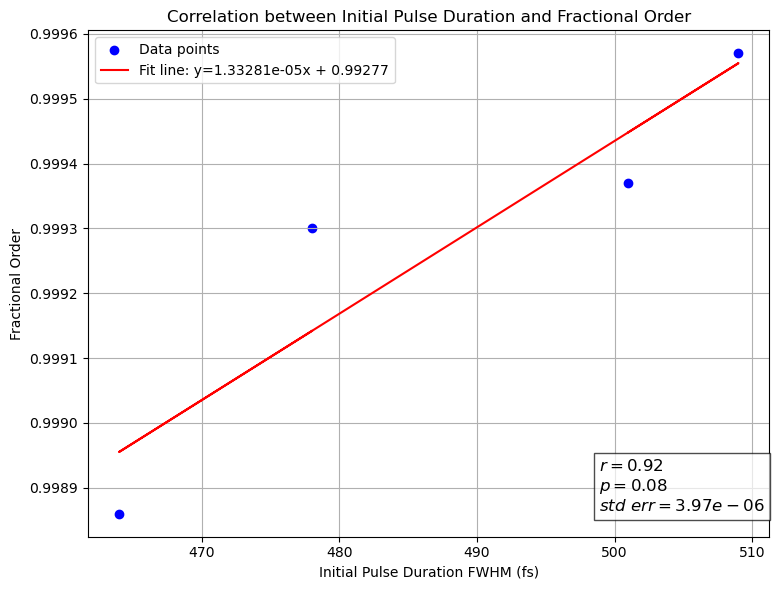

In [45]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress

# Data
fractional_orders = np.array([0.9993, 0.99886, 0.99957, 0.99937])
fwhm_times = np.array([478, 464, 509, 501])

# Linear regression
slope, intercept, r_value, p_value, std_err = linregress(fwhm_times, fractional_orders)
line = slope * fwhm_times + intercept

# Plot
plt.figure(figsize=(8,6))
plt.scatter(fwhm_times, fractional_orders, color='blue', label='Data points')
plt.plot(fwhm_times, line, color='red', label=f'Fit line: y={slope:.5e}x + {intercept:.5f}')
plt.xlabel('Initial Pulse Duration FWHM (fs)')
plt.ylabel('Fractional Order')
plt.title('Correlation between Initial Pulse Duration and Fractional Order')
plt.grid(True)
plt.legend()

# Add statistical metrics to the plot
textstr = '\n'.join((
    f'$r = {r_value:.2f}$',
    f'$p = {p_value:.2f}$',
    f'$std\\ err = {std_err:.2e}$'))
plt.text(0.75, 0.05, textstr, transform=plt.gca().transAxes,
         fontsize=12, bbox=dict(facecolor='white', alpha=0.7))

plt.tight_layout()
plt.show()

### 🔍 Interpretation of the Regression Output

#### **1. Correlation Coefficient (r = 0.92)**

* This is a **strong positive correlation** between **pulse duration (FWHM)** and **fractional order**.
* It suggests that **as pulse duration increases**, the fractional order **increases**.
* This is opposite of your initial hypothesis (you expected **longer pulses to reduce α**), so the data might contradict the expected physical behavior.

#### **2. p-value (p = 0.08)**

* This value is **statistically almost significant** (commonly, p < 0.05 is considered significant)..

#### **3. Standard Error (std err = 3.97e-06)**

* Indicates how precisely the regression line estimates the slope.
* It’s quite small, which means the estimate is reasonably stable.

---

### 🧠 **Observation Recap**

Your analysis found:

* **Longer pulse duration (FWHM)** correlates with **higher fractional order** α.
* This means **longer pulses behave more locally**, and **shorter pulses show more nonlocal (fractional) behavior**.

---

### ⚛️ Why does this happen?

This is likely due to **how ultrafast pulses interact with the medium (CO₂)** — especially regarding **nonlocality**, **memory effects**, and **fractional dynamics**.

---

### 🔍 1. **Fractional Order as a Measure of Nonlocality**

In fractional models:

* $\alpha = 1$: fully local propagation (classical Schrödinger).
* $\alpha < 1$: memory or nonlocal effects — e.g., **dispersion delay**, **coherence decay**, or **diffusive transport**.

So, **lower α** implies **more nonlocality** in the system.

---

### ⏱️ 2. **Shorter Pulses Interact More Nonlocally**

Short pulses (e.g., < 100 fs):

* Are **more broadband** (uncertainty principle).
* Can **excite a wider range of vibrational/rotational modes** in CO₂.
* This leads to **non-instantaneous** (delayed or history-dependent) responses.

These effects naturally favor **fractional (nonlocal)** behavior in space or time.

---

### 🪨 3. **Longer Pulses Average Out Nonlocal Effects**

Longer pulses:

* Interact with the medium more **smoothly**.
* The response appears **instantaneous** on that timescale.
* So the evolution resembles **local** (α ≈ 1) dynamics.

---

### 🔬 4. **In CO₂ at Low Pressure**

CO₂ gas at 0.5 bar:

* Has **low collision rates**, so the **medium retains memory** of past field interactions.
* This enhances **nonlocality** for shorter pulses.
* As pulse duration increases, the molecule’s memory becomes less relevant.

---